# Classification of raster timeseries with xr_fresh, geowombat and sklearn

In [1]:
import geowombat as gw
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import tempfile
from pathlib import Path
from xr_fresh.feature_calculator_series import (
    minimum,
    abs_energy,
    mean_abs_change,
    ratio_beyond_r_sigma,
    symmetry_looking,
    sum,
    quantile,
    function_mapping,
)

# make temp directory for outputs
temp_dir = Path(tempfile.mkdtemp())
# Set up error logging
import logging

# set up error logging
logging.basicConfig(
    filename=os.path.join(temp_dir, "error_log.log"),
    level=logging.ERROR,
    format="%(asctime)s:%(levelname)s:%(message)s",
)
# Read in example data
os.chdir("../xr_fresh/data/")

band_name = "ppt"  # used to rename outputs
file_glob = f"pdsi*tif"
strp_glob = f"pdsi_%Y%m_4500m.tif"

dates = sorted(
    datetime.strptime(string, strp_glob) for string in sorted(glob(file_glob))
)
files = sorted(glob(file_glob))

# print dates and files in a table
pd.DataFrame({"date": dates, "file": files})

/home/mmann1123/miniconda3/envs/xr_fresh_update/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,date,file
0,2018-01-01,pdsi_201801_4500m.tif
1,2018-02-01,pdsi_201802_4500m.tif
2,2018-03-01,pdsi_201803_4500m.tif
3,2018-04-01,pdsi_201804_4500m.tif
4,2018-05-01,pdsi_201805_4500m.tif
5,2018-06-01,pdsi_201806_4500m.tif
6,2018-07-01,pdsi_201807_4500m.tif
7,2018-08-01,pdsi_201808_4500m.tif
8,2018-09-01,pdsi_201809_4500m.tif
9,2018-10-01,pdsi_201810_4500m.tif


In [2]:



# create list of desired series
feature_list = {
    "minimum": [{}],
    "abs_energy": [{}],
    "mean_abs_change": [{}],
    "ratio_beyond_r_sigma": [{"r": 1}, {"r": 2}, {"r": 3}],
    "symmetry_looking": [{}],
    "sum": [{}],
    "quantile": [{"q": 0.05}, {"q": 0.95}],
}

with gw.series(files,nodata=-9999, window_size=[256, 256]) as src:
    # iterate across functions in feature list
    for func_name, param_list in feature_list.items():
        for params in param_list:

            # instantiate function & get parameter
            func_class = function_mapping.get(func_name)
            if func_class:
                func_instance = func_class(**params)  # Instantiate with parameters
                if len(params) > 0:
                    print(f"Instantiated {func_name} with  {params}")
                else:
                    print(f"Instantiated {func_name} ")

            # create output file name if parameters exist
            if len(list(params.keys())) > 0:
                key_names = list(params.keys())[0]
                value_names = list(params.values())[0]
                outfile = os.path.join(temp_dir,f"{band_name}_{func_name}_{key_names}_{value_names}.tif")
                # avoid issue with all dates
                if func_name in ["doy_of_maximum", "doy_of_minimum"]:
                    outfile = os.path.join(temp_dir,f"{band_name}_{func_name}_{key_names}.tif")
            else:
                outfile = os.path.join(temp_dir,f"{band_name}_{func_name}.tif")

            # extract features
            try:
                src.apply(
                    func=func_instance,
                    outfile=outfile,
                    num_workers=12,
                    processes=False,
                    bands=1,
                    kwargs={
                        "BIGTIFF": "YES",
                        "compress": "LZW",
                    },  # add bigtif if files are large
                )
            except Exception as e:
                logging.error(
                    f"Error extracting features from {band_name} {func_name}: {e}"
                )
                continue

Instantiated minimum 


100%|██████████| 4/4 [00:00<00:00, 85.48it/s]


Instantiated abs_energy 


100%|██████████| 4/4 [00:00<00:00, 56.73it/s]


Instantiated mean_abs_change 


100%|██████████| 4/4 [00:00<00:00, 37.20it/s]


Instantiated ratio_beyond_r_sigma with  {'r': 1}


100%|██████████| 4/4 [00:00<00:00, 10.72it/s]


Instantiated ratio_beyond_r_sigma with  {'r': 2}


100%|██████████| 4/4 [00:00<00:00, 6978.88it/s]


Instantiated ratio_beyond_r_sigma with  {'r': 3}


100%|██████████| 4/4 [00:00<00:00, 6246.17it/s]


Instantiated symmetry_looking 


100%|██████████| 4/4 [00:00<00:00, 12.77it/s]


Instantiated sum 


100%|██████████| 4/4 [00:00<00:00, 6649.71it/s]


Instantiated quantile with  {'q': 0.05}


100%|██████████| 4/4 [00:00<00:00, 65.80it/s]


Instantiated quantile with  {'q': 0.95}


100%|██████████| 4/4 [00:00<00:00, 6745.97it/s]


In [3]:
features = sorted(glob(os.path.join(temp_dir, "*.tif")))
feature_names = [os.path.basename(f).split(".")[0] for f in features]

pd.DataFrame({"feature": feature_names, "file": features})

,feature,file
0,ppt_abs_energy,/tmp/tmpp1cz7twv/ppt_abs_energy.tif
1,ppt_mean_abs_change,/tmp/tmpp1cz7twv/ppt_mean_abs_change.tif
2,ppt_minimum,/tmp/tmpp1cz7twv/ppt_minimum.tif
3,ppt_quantile_q_0,/tmp/tmpp1cz7twv/ppt_quantile_q_0.05.tif
4,ppt_quantile_q_0,/tmp/tmpp1cz7twv/ppt_quantile_q_0.95.tif
5,ppt_ratio_beyond_r_sigma_r_1,/tmp/tmpp1cz7twv/ppt_ratio_beyond_r_sigma_r_1.tif
6,ppt_ratio_beyond_r_sigma_r_2,/tmp/tmpp1cz7twv/ppt_ratio_beyond_r_sigma_r_2.tif
7,ppt_ratio_beyond_r_sigma_r_3,/tmp/tmpp1cz7twv/ppt_ratio_beyond_r_sigma_r_3.tif
8,ppt_sum,/tmp/tmpp1cz7twv/ppt_sum.tif
9,ppt_symmetry_looking,/tmp/tmpp1cz7twv/ppt_symmetry_looking.tif


## Create a unsupervised classification of timeseries features 

Note: You will need to install some additional features for `geowombat` by running

`mamba install geowombat-ml -c conda-forge`

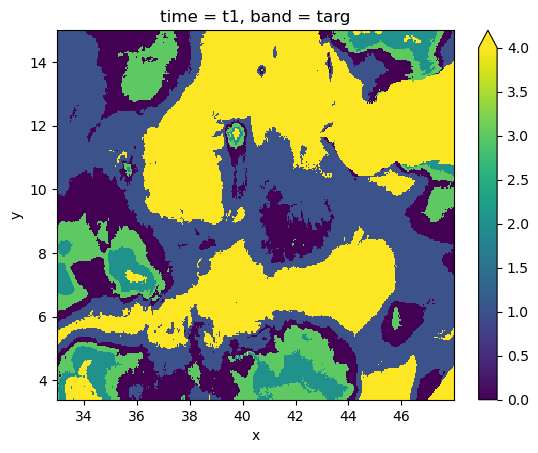

In [7]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from geowombat.ml import fit_predict
from sklearn.impute import SimpleImputer  
import numpy as np

cl = Pipeline(
    [
        ("remove_nan", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("clf", KMeans(n_clusters=6, random_state=0)),
    ]
)

# fit the pipeline and plot
with gw.open(features, stack_dim="band") as src:
    y = fit_predict(src, cl)
    y.plot(robust=True)